In [103]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [104]:
cwd_bird = os.path.join(os.getcwd(),"dataset/v_bird")
cwd_boat = os.path.join(os.getcwd(),"dataset/v_boat")
cwd_circus = os.path.join(os.getcwd(),"dataset/v_circus")
cwd_graffiti = os.path.join(os.getcwd(),"dataset/v_graffiti")
cwd_soldiers = os.path.join(os.getcwd(),"dataset/v_soldiers")
cwd_weapons = os.path.join(os.getcwd(),"dataset/v_weapons")

In [105]:
images_bird, images_boat, images_circus, images_graffiti, images_soldiers, images_weapons = list(), list(), list(), list(), list(), list()
images_bird_gray, images_boat_gray, images_circus_gray, images_graffiti_gray, images_soldiers_gray, images_weapons_gray = list(), list(), list(), list(), list(), list()



for img in os.listdir(cwd_bird):
    if (img[-3:] == "png"):
        images_bird.append(cv2.imread(cwd_bird + "/" + img))
        images_boat.append(cv2.imread(cwd_boat + "/" + img))
        images_circus.append(cv2.imread(cwd_circus + "/" + img))
        images_graffiti.append(cv2.imread(cwd_graffiti + "/" + img))
        images_soldiers.append(cv2.imread(cwd_soldiers + "/" + img))
        images_weapons.append(cv2.imread(cwd_weapons + "/" + img))

        images_bird_gray.append(cv2.imread(cwd_bird + "/" + img, cv2.IMREAD_GRAYSCALE))
        images_boat_gray.append(cv2.imread(cwd_boat + "/" + img, cv2.IMREAD_GRAYSCALE))
        images_circus_gray.append(cv2.imread(cwd_circus + "/" + img, cv2.IMREAD_GRAYSCALE))
        images_graffiti_gray.append(cv2.imread(cwd_graffiti + "/" + img, cv2.IMREAD_GRAYSCALE))
        images_soldiers_gray.append(cv2.imread(cwd_soldiers + "/" + img, cv2.IMREAD_GRAYSCALE))
        images_weapons_gray.append(cv2.imread(cwd_weapons + "/" + img, cv2.IMREAD_GRAYSCALE))

In [106]:
# select a image folder below.

"""
images_bird
images_boat
images_circus
images_graffiti
images_soldiers
images_weapons
"""

images = images_boat
images_gray = images_boat_gray

## Feature Extraction

In [107]:
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf', orb"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (keypoints, descriptors) = descriptor.detectAndCompute(image, None)
    
    return (keypoints,descriptors)

In [108]:
def get_key_and_des(images):

    key_and_des_sift, key_and_des_surf, key_and_des_orb = list(), list(), list()

    for img in images:
        key_and_des_sift.append(detectAndDescribe(img, "sift"))
        key_and_des_surf.append(detectAndDescribe(img, "surf"))
        key_and_des_orb.append(detectAndDescribe(img, "orb"))

    return key_and_des_sift, key_and_des_surf, key_and_des_orb

In [109]:
key_and_des_sift, key_and_des_surf, key_and_des_orb = get_key_and_des(images)

In [110]:
# display the keypoints and features detected on both images

def display_keypoints(key_and_des, method):

    fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(20,8), constrained_layout=False)

    axes = (ax1,ax2,ax3,ax4,ax5,ax6)

    for i in range(len(images)):

        axes[i].imshow(cv2.drawKeypoints(images_gray[i],key_and_des[i][0],None,color=(0,255,0)))
        axes[i].set_xlabel("img{}".format(i+1), fontsize=10)

    fig.suptitle( method.upper(), fontsize=16)
    plt.show()


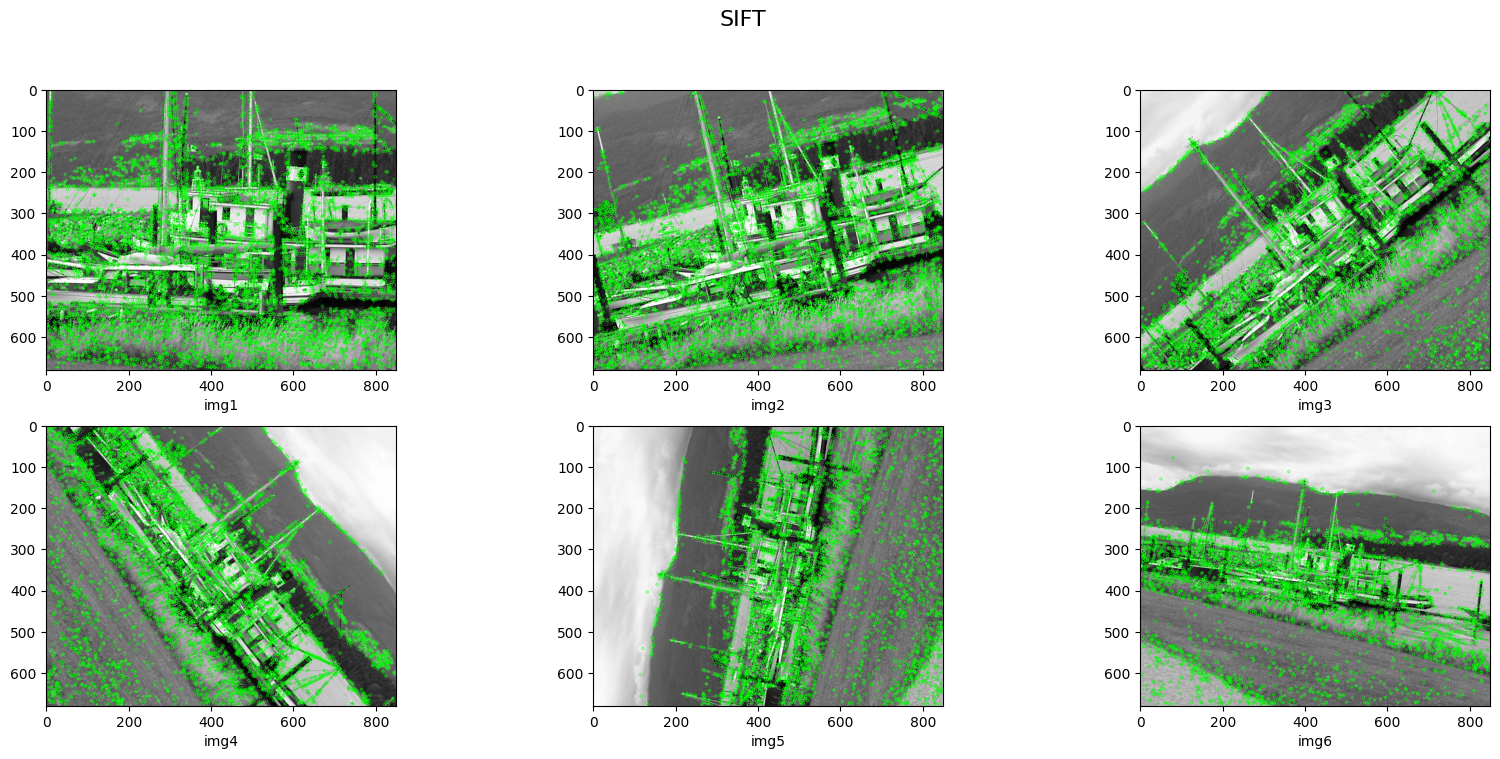

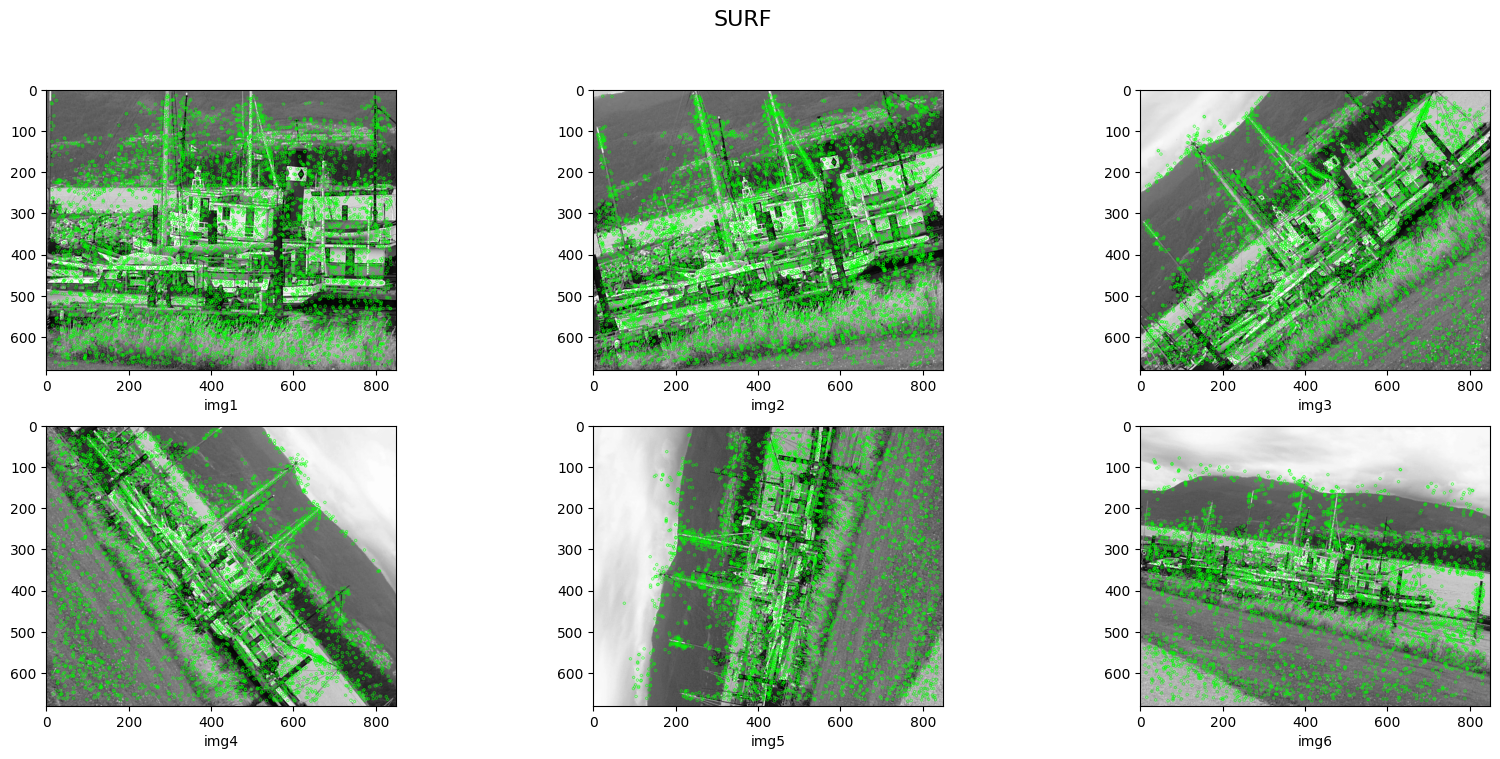

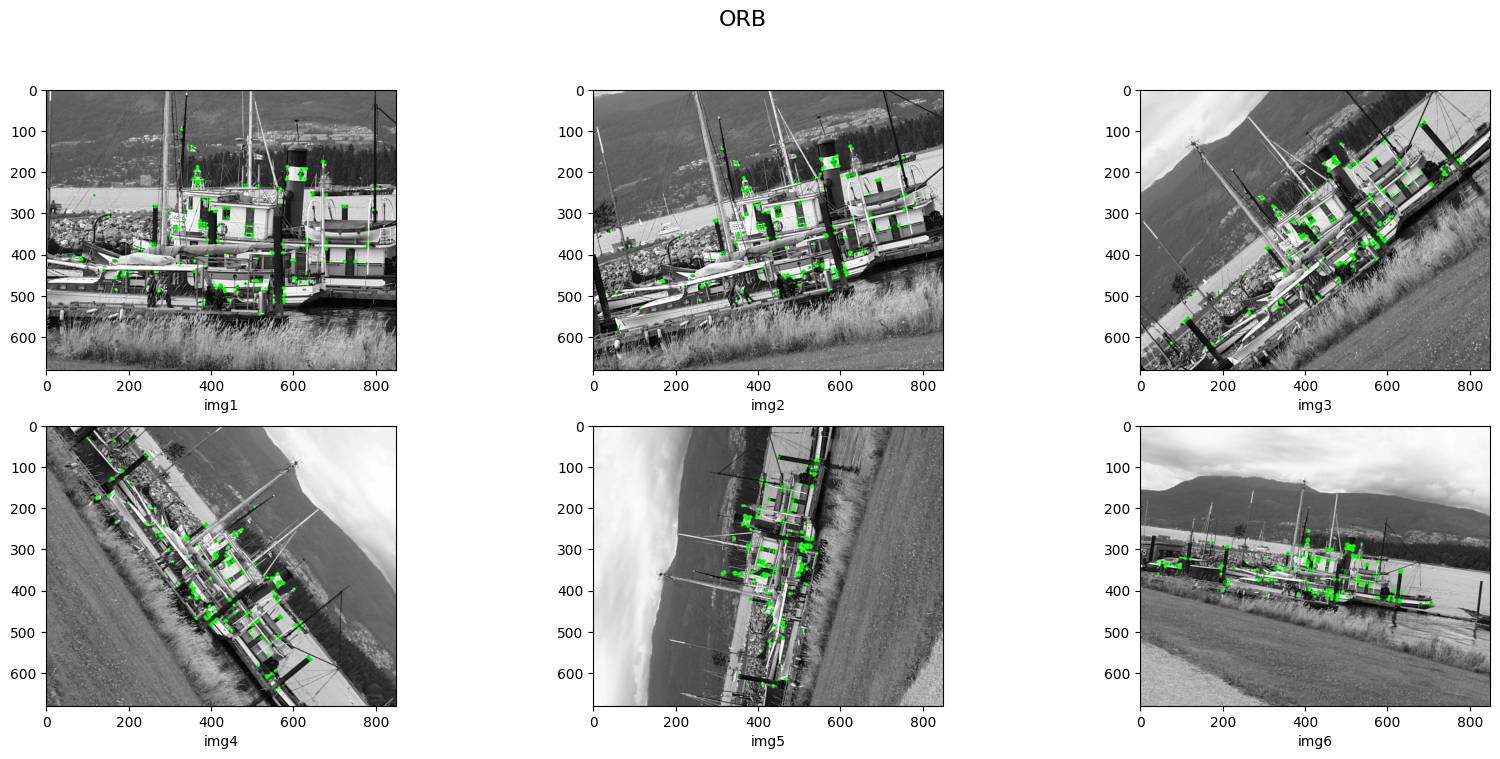

In [111]:
display_keypoints(key_and_des_sift,"sift")
display_keypoints(key_and_des_surf,"surf")
display_keypoints(key_and_des_orb,"orb")

## Feature Matching

In [112]:
def createMatcher(method,crossCheck):
    "Return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [113]:
def matchKeyPointsKNN(descriptorsA, descriptorsB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the crude matches and initialize the list of actual matches
    crudeMatches = bf.knnMatch(descriptorsA, descriptorsB, 2)
    matches = []

    # loop over the crude matches
    for m,n in crudeMatches:

        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

In [114]:
def display_matches(key_and_des,method):
    fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(20,8), constrained_layout=False)

    axes = (ax1,ax2,ax3,ax4,ax5,ax6)

    matches = list()

    for i in range(len(images)-1):

        match = matchKeyPointsKNN(key_and_des[0][1], key_and_des[i+1][1], ratio=0.75, method=method)
        img = cv2.drawMatches(images[0],key_and_des[0][0],images[i+1],key_and_des[i+1][0],np.random.choice(match,100), None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,matchColor=(0,255,0))
        axes[i].imshow(img)
        axes[i].set_xlabel("img1-{}".format(i+2), fontsize=10)
        matches.append(match)

    fig.suptitle(method.upper(), fontsize=16)
    plt.show()

    return matches

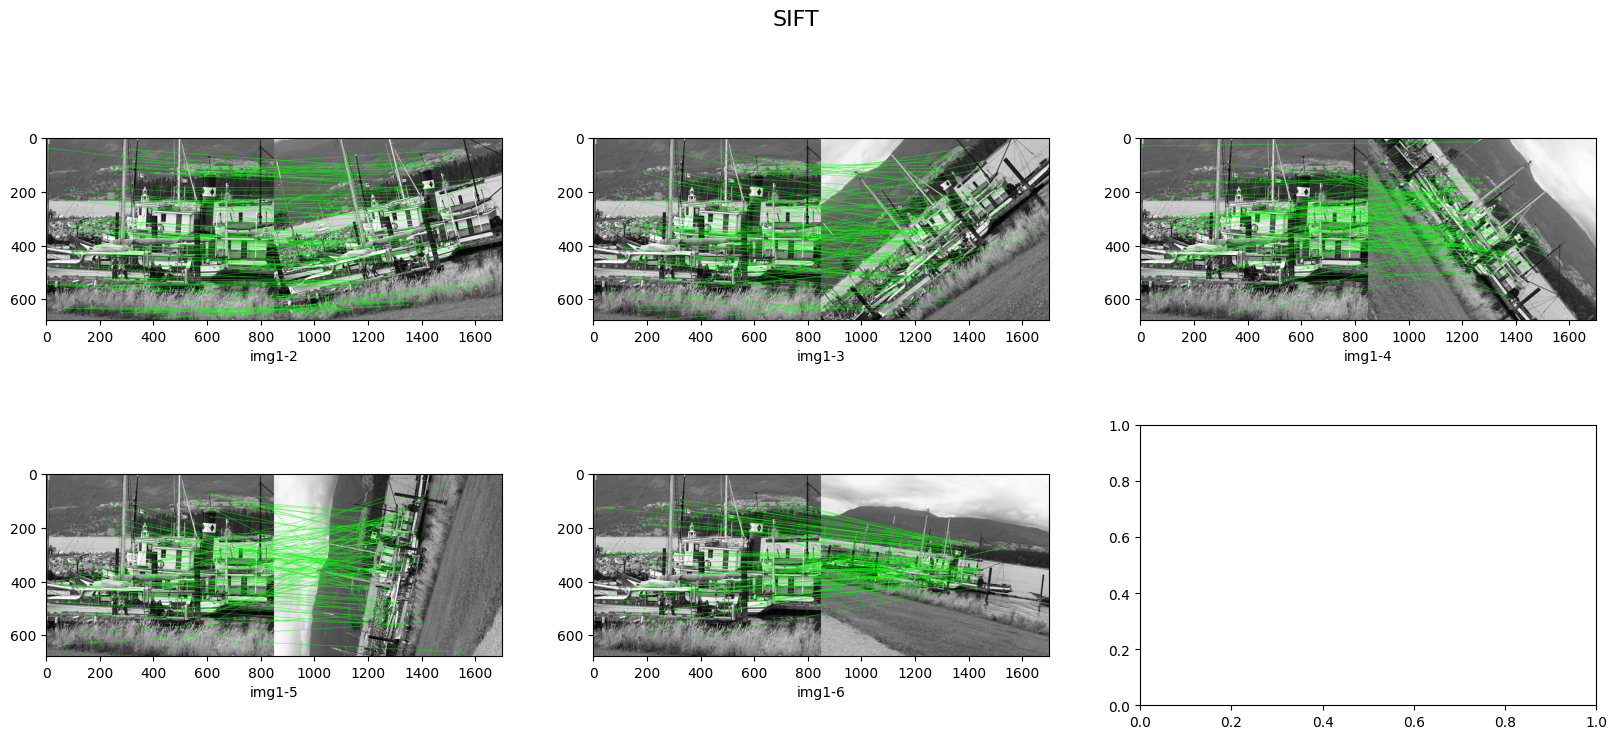

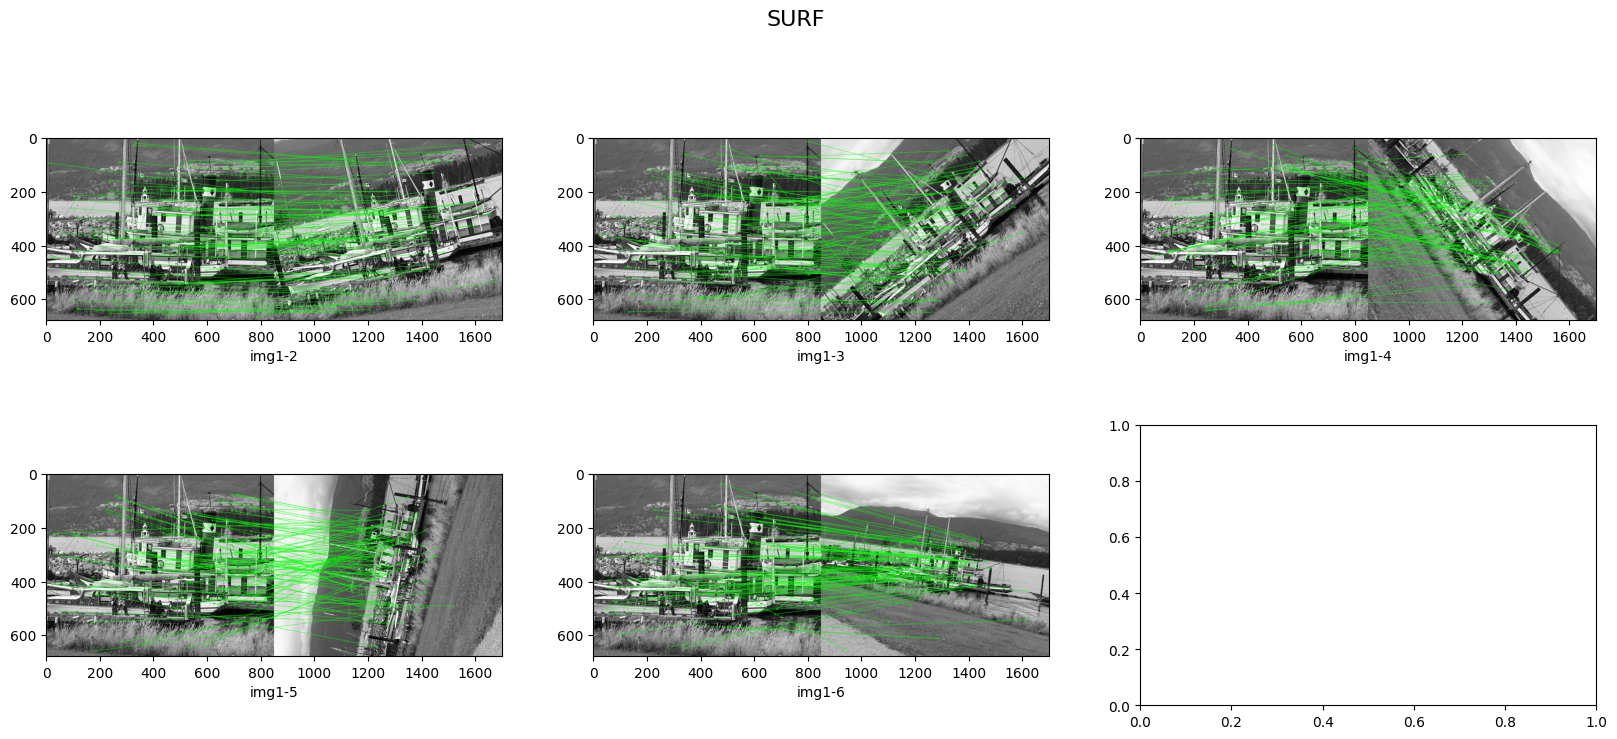

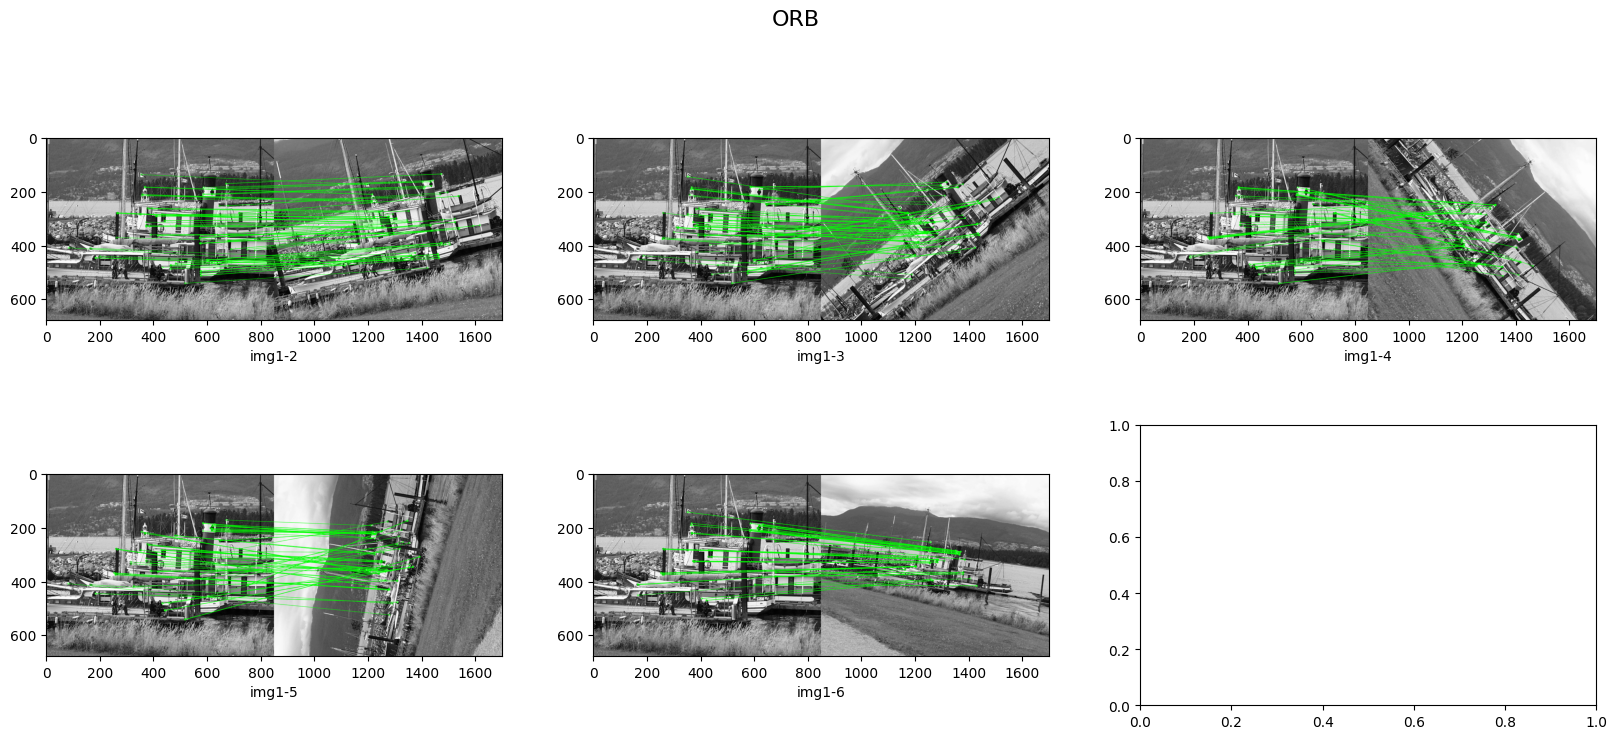

In [115]:
matches_sift = display_matches(key_and_des_sift,"sift")
matches_surf = display_matches(key_and_des_surf,"surf")
matches_orb = display_matches(key_and_des_orb,"orb")

## Finding Homography

In [116]:
def getHomography(keypoints1, keypoints2, matches, threshold):
    # convert the keypoints to numpy arrays
    keypoints1 = np.float32([kp.pt for kp in keypoints1])
    keypoints2 = np.float32([kp.pt for kp in keypoints2])
    
    if len(matches) > 4:

        # construct the two sets of points
        points1 = np.float32([keypoints1[m.queryIdx] for m in matches])
        points2 = np.float32([keypoints2[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(points1, points2, cv2.RANSAC, threshold)

        return (matches, H, status)
    else:
        return None

In [117]:
homographies_sift, homographies_surf, homographies_orb = list(), list(), list()

for i in range(len(images)-1):

    homography_sift = getHomography(key_and_des_sift[0][0], key_and_des_sift[i+1][0], matches_sift[i], threshold=4)
    homography_surf = getHomography(key_and_des_surf[0][0], key_and_des_surf[i+1][0], matches_surf[i], threshold=4)
    homography_orb = getHomography(key_and_des_orb[0][0], key_and_des_orb[i+1][0], matches_orb[i], threshold=4)

    if homography_sift is None or homography_surf is None or homography_orb is None:
        print("Error!")

    homographies_sift.append(homography_sift)
    homographies_surf.append(homography_surf)
    homographies_orb.append(homography_orb)


np.set_printoptions(suppress=True)


print("SIFT HOMOGRAPHY MATRİX")
for matches, H, status in homographies_sift:
    print("\n",H)

print("\n\nSURF HOMOGRAPHY MATRİX")
for matches, H, status in homographies_surf:
    print("\n",H)

print("\n\nORB HOMOGRAPHY MATRİX")
for matches, H, status in homographies_orb:
    print("\n",H)

SIFT HOMOGRAPHY MATRİX

 [[  0.85748622   0.215868     9.88956924]
 [ -0.21190405   0.85828649 130.67996573]
 [  0.00000145   0.00000061   1.        ]]

 [[  0.56888562   0.47036018  25.47978904]
 [ -0.4677974    0.56555672 348.43350234]
 [  0.00000657  -0.00000077   1.        ]]

 [[  0.39270597  -0.48699155 421.93669438]
 [  0.48636828   0.3944544   -0.24010195]
 [  0.00000316  -0.00000336   1.        ]]

 [[  0.10245629   0.52978426 204.95899044]
 [ -0.52420641   0.09291024 534.63187895]
 [  0.00001357  -0.00000063   1.        ]]

 [[  0.42374104  -0.05896276 266.04037722]
 [  0.06227987   0.4184918  174.66692331]
 [  0.00001282  -0.00000677   1.        ]]


SURF HOMOGRAPHY MATRİX

 [[  0.85748564   0.21689817   9.78322423]
 [ -0.21216386   0.85989975 130.37305833]
 [  0.00000064   0.00000291   1.        ]]

 [[  0.56791731   0.4710777   25.11772339]
 [ -0.46838974   0.56403015 348.70348609]
 [  0.00000411  -0.00000039   1.        ]]

 [[  0.39514023  -0.49159315 422.14264463]
 [  0

## Merging by Transformation

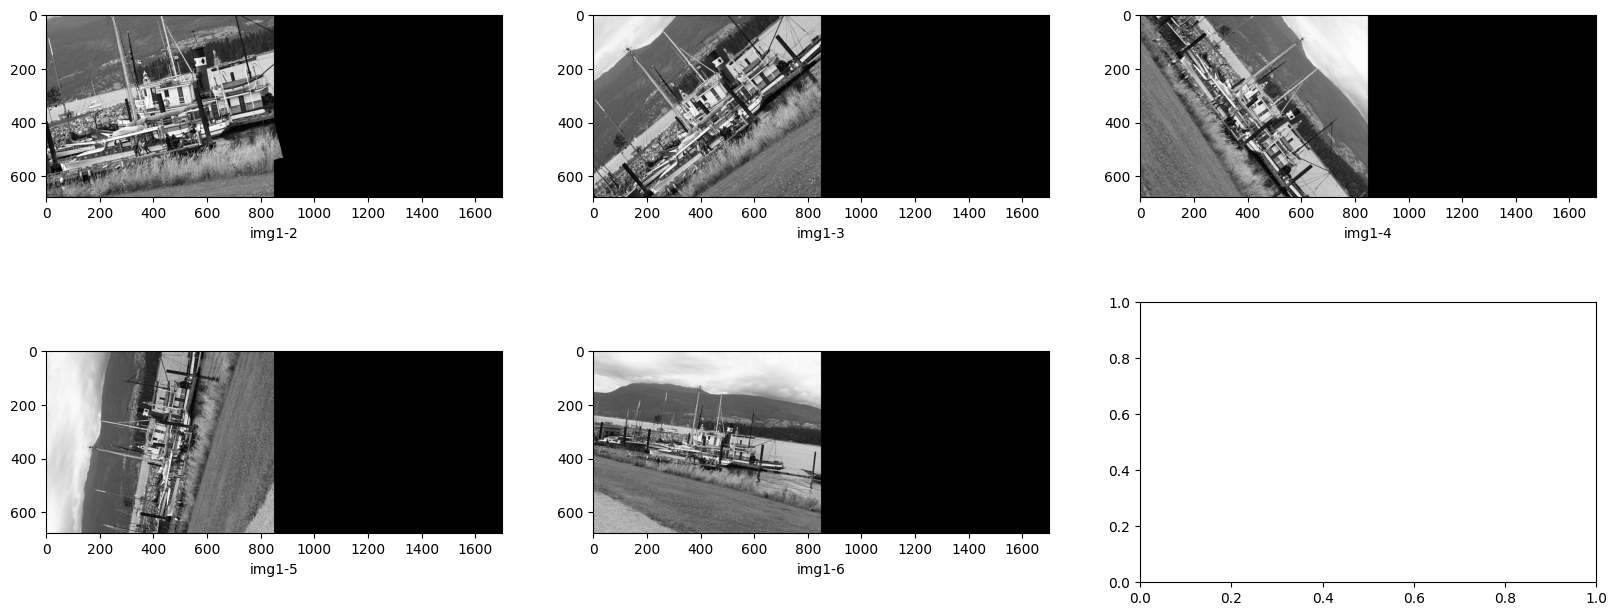

In [118]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(20,8), constrained_layout=False)

axes = (ax1,ax2,ax3,ax4,ax5,ax6)

for i in range(len(images)-1):

    dst = cv2.warpPerspective(images[0],homographies_sift[i][1],((images[0].shape[1] + images[i+1].shape[1]), images[i+1].shape[0])) #wraped image
    dst[0:images[i+1].shape[0], 0:images[i+1].shape[1]] = images[i+1] #stitched image
    axes[i].imshow(dst)
    axes[i].set_xlabel("img1-{}".format(i+2), fontsize=10)


plt.show()